# Ch 5.1 Multiple Linear Regression

In [1]:
import pandas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz
import cmdstanpy
import statsmodels.api as sm
import math
from scipy import stats

In [2]:
import os, sys

os.chdir('../../chap05')
print("Current working directory:", os.getcwd())

Current working directory: c:\git\Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python\chap05


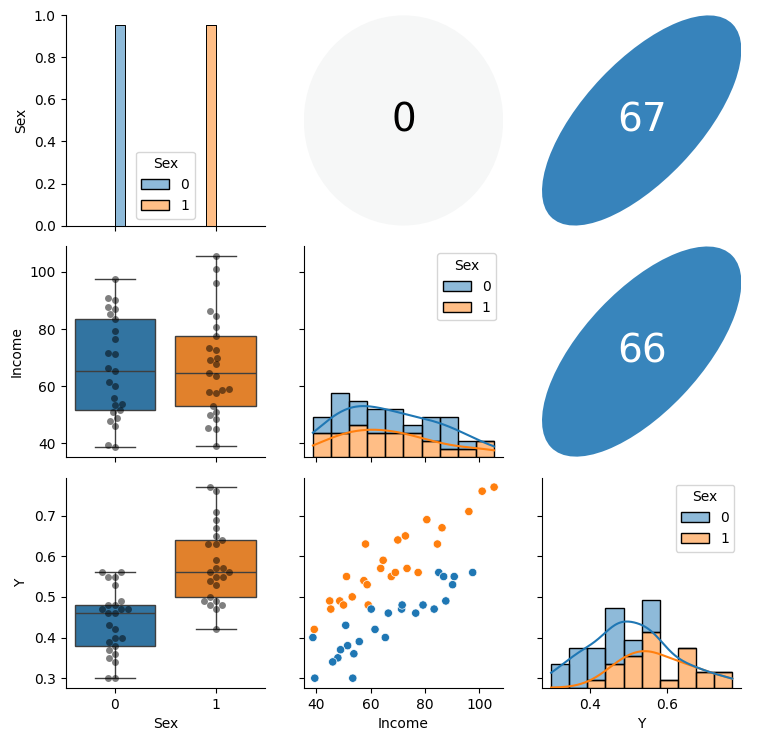

In [3]:
d = pandas.read_csv('input/data-shopping-1.csv')
d.drop(columns='PersonID', inplace=True)

def plot_lower(x, y, **kws):
    d_ = pandas.DataFrame({'x':x, 'y':y, 'Sex':d.Sex})
    if x.nunique() < 5:
        sns.boxplot(data=d_, x='x', y='y', hue='Sex')
        sns.swarmplot(data=d_, x='x', y='y', color='black', alpha=0.5)
    else:
        sns.scatterplot(data=d_, x='x', y='y', hue='Sex')

def plot_diag(x, **kws):    
    d_ = pandas.DataFrame({'x':x, 'Sex':d.Sex})
    sns.histplot(data=d_, x='x', hue='Sex', multiple='stack', kde=True, bins=10)

def plot_upper(x, y, **kws):
    from matplotlib.patches import Ellipse
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.0f}'.format(r*100), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

g = sns.PairGrid(d)
g.map_lower(plot_lower)
g.map_diag(plot_diag)
g.map_upper(plot_upper)
g.add_legend();

### Theoretical Explanation of the p-value for Spearman's Correlation Coefficient

The p-value associated with the Spearman correlation coefficient is a crucial statistical measure that helps you determine the significance of the correlation between two variables. It provides a way to assess whether the observed monotonic relationship is likely to exist in the overall population or if it's just a result of random chance in your sample.

#### 1. The Null and Alternative Hypotheses
To understand the p-value, we first need to define the hypotheses:

- Null Hypothesis (H₀): This hypothesis states that there is no monotonic relationship between the two variables in the population. In other words, the true Spearman correlation coefficient (ρ) is zero.

H₀: ρ = 0

- Alternative Hypothesis (H₁): This hypothesis proposes that there is a monotonic relationship between the two variables. This means the Spearman correlation coefficient (ρ) is not zero. It can be a two-sided test (ρ ≠ 0) or a one-sided test (ρ > 0 or ρ < 0).

H₁: ρ ≠ 0

#### 2. What the p-value Represents
The p-value is the probability of observing a Spearman correlation coefficient as extreme as, or more extreme than, the one computed from your sample data, assuming that the null hypothesis is true.

- A small p-value suggests that it is very unlikely you would observe such a strong correlation if there were no actual relationship between the variables. This gives you a reason to doubt the null hypothesis.
- A large p-value suggests that the observed correlation could have easily occurred by random chance, so there is no strong reason to reject the null hypothesis.

#### 3. Interpreting the p-value
To make a decision, you compare the p-value to a pre-determined significance level (α), which is typically set to 0.05 (or 5%).

- If p-value < α (e.g., p < 0.05):
You reject the null hypothesis.
You conclude that the correlation is statistically significant.
This means there is strong evidence for a monotonic relationship between the two variables.
- If p-value ≥ α (e.g., p ≥ 0.05):
You fail to reject the null hypothesis.
You conclude that the correlation is not statistically significant.
This means there is not enough evidence to say that a monotonic relationship exists between the variables.

#### 4. How the p-value is Calculated
The calculation of the p-value depends on the sample size:

For small sample sizes, the exact p-value is often calculated using permutation tests, which consider all possible orderings of the data ranks.

For larger sample sizes (typically n > 20), the distribution of the Spearman correlation coefficient can be approximated by a t-distribution. The test statistic t is calculated as follows:

<img alt="t-statistic formula" src="https://latex.codecogs.com/svg.latex?t = r_s \sqrt{\frac{n-2}{1-r_s^2}}">
where:

- `r_s` is the sample Spearman correlation coefficient.
- `n` is the sample size.
This t-statistic follows a t-distribution with n-2 degrees of freedom. The p-value is then determined from this distribution.

In summary, the p-value provides a formal way to test the significance of a Spearman correlation, helping you distinguish between a meaningful relationship and one that could be due to random sampling variability.

#### Correlation Coefficients
1. Pearson Correlation
   $$
        r_p = \sum_i (X_i - {\bar X})(Y_i - {\bar Y}) / std(X) std(Y)
   $$
2. Spearman's (Rank) Correlation
   $$
         rank_X = sort\_index(X) \\
         rank_Y = sort\_index(Y) \\
         r_s = PersonCorrelation(rank_X, rank_Y)
   $$

In [4]:
np.random.seed(123)
X = np.random.randint(100, size=5)
Y = np.random.randint(100, size=5)
print(X, Y)

def pearsonr(X,Y):
    mx = X.mean()
    my = Y.mean()
    r = ((X - mx) * (Y - my)).mean() / (X.std() * Y.std())
    return r

print("Pearson R:", pearsonr(X,Y))
print(stats.pearsonr(X,Y))

def spearmanr(X,Y):
    rankX = np.argsort(X)
    rankY = np.argsort(Y)
    return pearsonr(rankX, rankY)

print("Spearman R:", spearmanr(X,Y))
print(stats.spearmanr(X,Y))

[66 92 98 17 83] [57 86 97 96 47]
Pearson R: -0.18440598378545028
PearsonRResult(statistic=np.float64(-0.1844059837854502), pvalue=np.float64(0.7665445921819646))
Spearman R: 0.29999999999999993
SignificanceResult(statistic=np.float64(0.3), pvalue=np.float64(0.6238376647810728))


## Let's Run Stan Model


#### Warning: A Flawed Assumption: The Normal Distribution
Your outcome Y is constrained: `vector<lower=0, upper=1>[N]`. However, you are modeling it with a Normal distribution (`Y ~ normal(mu, sigma)`).

A Normal distribution's support is from (−∞,∞). It can generate values below 0 and above 1. This is a fundamental mismatch between your data's properties and your model's assumption. This misspecification makes the model's job harder and contributes to the numerical instability.

##### How to Fix It 👍
1. Standardize Your Predictors: This is the most important step. Before passing data to Stan, you should standardize your continuous predictors like Income. This involves subtracting the mean and dividing by the standard deviation. This will rescale Income to have a mean of 0 and a standard deviation of 1, putting it on a similar scale as Sex and Y and preventing mu from exploding.

1. Choose an Appropriate Likelihood: You should use a distribution designed for data between 0 and 1.

    - If Y is continuous (proportions): Use Beta Regression. The Beta distribution is defined on the interval (0, 1) and is perfect for this type of data. The likelihood would change to something like `Y ~ beta(mu * phi, (1 - mu) * phi)`.

    - If Y is binary (only 0s and 1s): Use Logistic Regression. The data type for Y should be array[N] int and the likelihood should be Y ~ bernoulli_logit(mu).

1. Use Tighter Priors: After standardizing your predictors, a prior of normal(0, 100) is excessively wide. A more reasonable, weakly informative prior like b ~ normal(0, 1) is a much better starting point.

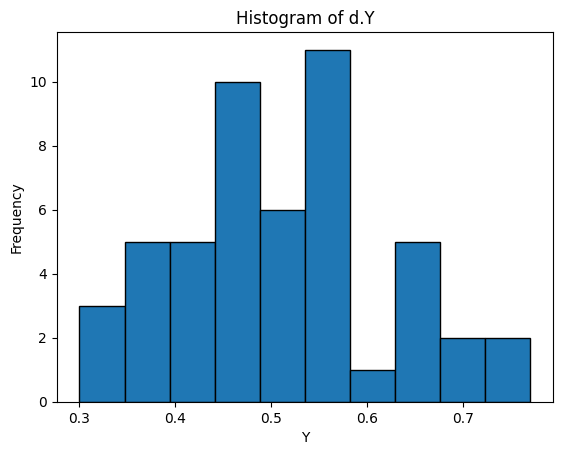

In [5]:
plt.hist(d.Y, bins=10, edgecolor='black')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.title('Histogram of d.Y')
plt.show()

In [6]:
np.random.seed(123)

d = pandas.read_csv('input/data-shopping-1.csv')
d.Income /= 100
Y_sim_mean = 0.2 + 0.15*d.Sex + 0.4*d.Income
Y_sim = np.random.normal(loc=Y_sim_mean, scale=0.1)
data = d.to_dict('list')
data.update({'N':len(d)})
data_sim = data.copy()
data_sim['Y'] = Y_sim

model = cmdstanpy.CmdStanModel(stan_file='model/model5-3.stan')
fit_sim = model.sample(data=data_sim, seed=123, parallel_chains=4)
fit     = model.sample(data=data,     seed=123, parallel_chains=4)

13:54:28 - cmdstanpy - INFO - compiling stan file C:\git\Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python\chap05\model\model5-3.stan to exe file C:\git\Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python\chap05\model\model5-3.exe
13:54:51 - cmdstanpy - INFO - compiled model executable: C:\git\Matsuura2022_Bayesian_Statistical_Modeling_with_Stan_R_and_Python\chap05\model\model5-3.exe
13:54:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:54:51 - cmdstanpy - INFO - CmdStan done processing.
13:54:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model5-3.stan', line 18, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!
13:54:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:54:52 - cmdstanpy - INFO - CmdStan done processing.
13:54:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model5-3.stan', line 18, column 2 to column 34)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model5-3.stan', line 18, column 2 to column 34)
Consider re-running with show_console=True if the above output is unclear!


In [7]:
# You can access the Stan source code from the model object using the .code() method.
print(model.code())

data {
  int N;
  vector<lower=0, upper=1>[N] Sex;
  vector<lower=0>[N] Income;
  vector<lower=0, upper=1>[N] Y;
}

parameters {
  vector[3] b;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = b[1] + b[2]*Sex[1:N] + b[3]*Income[1:N];
}

model {
  Y[1:N] ~ normal(mu[1:N], sigma);
}

generated quantities {
  array[N] real yp = normal_rng(mu[1:N], sigma);
}



In [11]:
fit_sim.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,78.250300,0.042505,1.507710,1.323960,75.336100,78.574300,80.032000,1356.20,1644.73,1.002730
b[1],0.246860,0.001787,0.073488,0.073965,0.126689,0.246476,0.368848,1710.47,1782.35,1.004020
b[2],0.099376,0.000752,0.035743,0.034982,0.040422,0.099112,0.157452,2293.45,1988.10,1.001250
b[3],0.369707,0.002479,0.103029,0.103002,0.200172,0.368630,0.542318,1779.88,1870.90,1.003640
sigma,0.123672,0.000281,0.013331,0.012836,0.103904,0.122240,0.147377,2366.23,2291.80,1.000820
...,...,...,...,...,...,...,...,...,...,...
yp[46],0.511496,0.002068,0.128227,0.130885,0.301855,0.510101,0.719805,3853.60,3774.02,0.999657
yp[47],0.429199,0.002059,0.126752,0.123326,0.217234,0.430716,0.636552,3815.61,3207.58,0.999776
yp[48],0.537827,0.002161,0.130948,0.129776,0.322742,0.539086,0.753681,3676.73,3680.54,1.000130
yp[49],0.444317,0.002071,0.129655,0.128080,0.232112,0.444462,0.657676,3953.21,4013.28,0.999754


In [13]:
df_sim = fit_sim.draws_pd()
df_sim.head()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,...,yp[41],yp[42],yp[43],yp[44],yp[45],yp[46],yp[47],yp[48],yp[49],yp[50]
0,1.0,1.0,1.0,78.7101,0.998479,0.144166,4.0,31.0,0.0,-76.0622,...,0.636979,0.587043,0.567885,0.622732,0.510880,0.470269,0.359556,0.523783,0.393393,0.448206
1,1.0,2.0,2.0,78.2722,0.842794,0.144166,2.0,7.0,0.0,-77.1279,...,0.578514,0.423390,0.553296,0.479522,0.333589,0.578554,0.570463,0.348103,0.491500,0.591504
2,1.0,3.0,3.0,78.6018,0.945874,0.144166,5.0,31.0,0.0,-76.7230,...,0.471357,0.502107,0.492343,0.504061,0.382262,0.572452,0.408432,0.507260,0.326387,0.548616
3,1.0,4.0,4.0,79.6985,0.999940,0.144166,5.0,31.0,0.0,-78.4803,...,0.754729,0.270652,0.501472,0.325773,0.421181,0.479294,0.414221,0.539809,0.372374,0.705463
4,1.0,5.0,5.0,79.7564,0.988635,0.144166,3.0,15.0,0.0,-78.7388,...,0.418601,0.111031,0.458240,0.482868,0.655960,0.426725,0.440311,0.332549,0.299978,0.408619


In [15]:
# Extract only parameter columns from df_sim (exclude diagnostics and generated quantities)
parameter_cols = [col for col in df_sim.columns if not (col.startswith('chain__') or
                                                       col.startswith('iter__') or
                                                       col.startswith('draw__') or
                                                       col.startswith('lp__') or
                                                       col.endswith('__') or
                                                       col.startswith('accept_stat__') or
                                                       col.startswith('stepsize__') or
                                                       col.startswith('treedepth__') or
                                                       col.startswith('n_leapfrog__') or
                                                       col.startswith('divergent__') or
                                                       col.startswith('energy__') )]

df_sim_params = df_sim[parameter_cols]
df_sim_params.head()

,b[1],b[2],b[3],sigma,mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],...,yp[41],yp[42],yp[43],yp[44],yp[45],yp[46],yp[47],yp[48],yp[49],yp[50]
0,0.187269,0.108381,0.451704,0.101180,0.571668,0.587450,0.628131,0.624490,0.526470,0.579799,...,0.636979,0.587043,0.567885,0.622732,0.510880,0.470269,0.359556,0.523783,0.393393,0.448206
1,0.177884,0.106554,0.438796,0.102913,0.551300,0.567900,0.606149,0.603881,0.508663,0.559198,...,0.578514,0.423390,0.553296,0.479522,0.333589,0.578554,0.570463,0.348103,0.491500,0.591504
2,0.288519,0.112503,0.338028,0.110604,0.576181,0.619389,0.618434,0.647107,0.573755,0.582265,...,0.471357,0.502107,0.492343,0.504061,0.382262,0.572452,0.408432,0.507260,0.326387,0.548616
3,0.251342,0.079044,0.355231,0.115026,0.553643,0.559865,0.598047,0.588994,0.511908,0.560037,...,0.754729,0.270652,0.501472,0.325773,0.421181,0.479294,0.414221,0.539809,0.372374,0.705463
4,0.233372,0.120167,0.350159,0.121146,0.531357,0.579741,0.575127,0.608454,0.532470,0.537660,...,0.418601,0.111031,0.458240,0.482868,0.655960,0.426725,0.440311,0.332549,0.299978,0.408619


In [17]:
df_sim_params.describe()

,b[1],b[2],b[3],sigma,mu[1],mu[2],mu[3],mu[4],mu[5],mu[6],...,yp[41],yp[42],yp[43],yp[44],yp[45],yp[46],yp[47],yp[48],yp[49],yp[50]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.246860,0.099376,0.369707,0.123672,0.561481,0.585067,0.607695,0.615383,0.535156,0.568136,...,0.582969,0.434348,0.486424,0.454155,0.467897,0.511496,0.429199,0.537827,0.444317,0.607152
std,0.073488,0.035743,0.103029,0.013331,0.032005,0.025264,0.040946,0.026017,0.029760,0.033133,...,0.128922,0.126380,0.129356,0.126714,0.127318,0.128227,0.126752,0.130948,0.129655,0.126938
min,0.002496,-0.034587,0.019719,0.085557,0.438331,0.502306,0.447163,0.527440,0.424565,0.439603,...,0.138638,-0.052258,-0.037247,0.019645,-0.049521,0.064604,-0.076384,-0.024084,-0.095113,0.055261
25%,0.197936,0.076066,0.302437,0.114165,0.540095,0.568594,0.580849,0.598195,0.515262,0.546069,...,0.495175,0.351579,0.395671,0.368905,0.382725,0.424087,0.344972,0.451671,0.355711,0.524425
50%,0.246476,0.099112,0.368630,0.122240,0.561759,0.584904,0.607820,0.615433,0.534782,0.568172,...,0.583705,0.433523,0.487920,0.452397,0.467578,0.510101,0.430716,0.539086,0.444462,0.607730
75%,0.297714,0.123201,0.440251,0.131714,0.583026,0.601771,0.635116,0.633165,0.555515,0.590258,...,0.668581,0.517158,0.573972,0.538487,0.552653,0.600106,0.511273,0.626660,0.529123,0.693206
max,0.475526,0.224429,0.698857,0.202507,0.671243,0.673090,0.754665,0.706980,0.653242,0.682346,...,1.033000,0.863517,0.899540,0.929412,0.919099,0.940575,0.934500,1.095030,0.943866,1.126980


In [18]:
fit.summary()

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,135.968000,0.041486,1.514600,1.217210,133.054000,136.329000,137.666000,1398.71,1969.45,1.002290
b[1],0.147584,0.000563,0.022115,0.021426,0.111332,0.147370,0.183943,1567.37,1768.38,1.002520
b[2],0.138370,0.000211,0.010622,0.010332,0.121050,0.138418,0.155895,2587.26,2178.50,1.001450
b[3],0.437958,0.000781,0.031036,0.030095,0.388799,0.437748,0.488363,1594.70,1885.44,1.002370
sigma,0.038024,0.000087,0.004088,0.004080,0.031864,0.037740,0.045206,2230.93,2328.13,1.000930
...,...,...,...,...,...,...,...,...,...,...
yp[46],0.460510,0.000629,0.038943,0.039042,0.397056,0.460197,0.524963,3840.73,3962.31,1.000360
yp[47],0.363118,0.000626,0.039126,0.040322,0.299033,0.363327,0.425208,3925.43,3841.62,1.000090
yp[48],0.493310,0.000631,0.039255,0.037766,0.428624,0.493838,0.558194,3938.82,3764.62,1.000270
yp[49],0.381055,0.000639,0.039361,0.037806,0.317124,0.380593,0.446010,3794.08,3774.84,0.999758


In [22]:
df = fit.draws_pd()
param = df[['b[1]', 'b[2]', 'b[3]', 'sigma']]
param

,b[1],b[2],b[3],sigma
0,0.145587,0.135823,0.433097,0.034740
1,0.152636,0.148733,0.412295,0.041106
2,0.156753,0.147123,0.411386,0.041356
3,0.158423,0.144462,0.425179,0.043938
4,0.172246,0.135968,0.399482,0.033201
...,...,...,...,...
3995,0.124649,0.137297,0.461374,0.034955
3996,0.121246,0.131490,0.475267,0.041000
3997,0.131339,0.151844,0.447697,0.033957
3998,0.164351,0.143604,0.413240,0.039459


#### Posterior Predictive Check (PPC)

- Posterior predictive check (PPC) is to overlay the posterior predictive distribution and data distribution on a single plot. 
- By visualizing them together and check if there is a large discrepancy, we can assess whether the assumed model is proper for the given data.

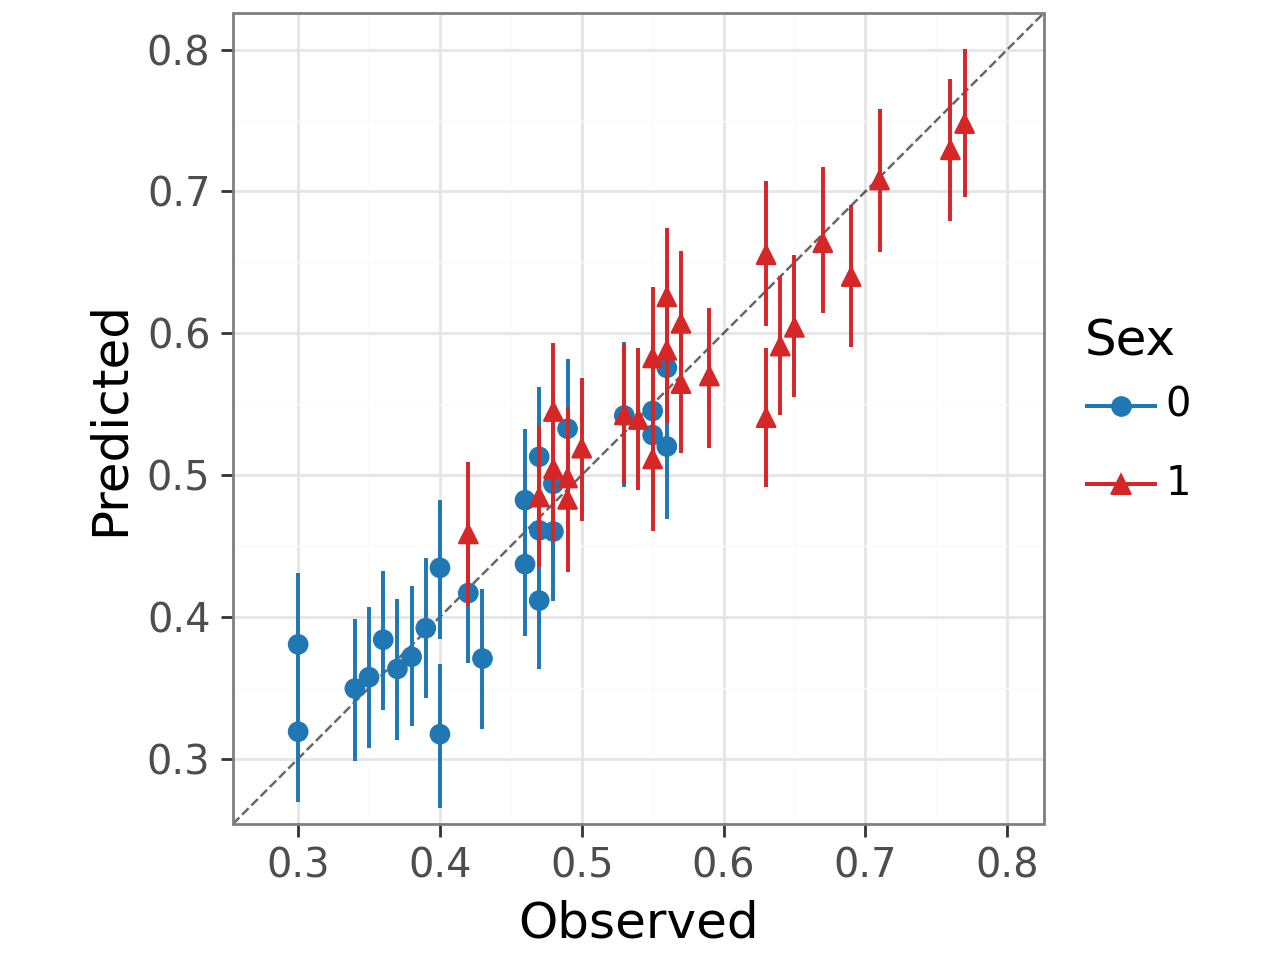

In [30]:
from plotnine import *

yp_ms = fit.stan_variable(var='yp')

qua = np.quantile(yp_ms, [0.1, 0.50, 0.9], axis=0)
d_qua = pandas.DataFrame(qua.T, columns=['10%', '50%', '90%'])
d_est = pandas.concat([d, d_qua], axis=1)

p = (ggplot(d_est, aes(x='Y', y='50%', ymin='10%', ymax='90%', shape='factor(Sex)', color='factor(Sex)', fill='factor(Sex)'))
    + theme_bw(base_size=18)
    + coord_fixed(ratio=1, xlim=[0.28, .8], ylim=[0.28, .8])
    + geom_abline(aes(slope=1, intercept=0), color='black', alpha=3/5, linetype='dashed')
    + geom_pointrange(size=0.8)
    + scale_shape_manual(values=['o', '^'])
    + scale_color_manual(values=['#1f77b4', '#d62728'])
    + scale_fill_manual(values=['#1f77b4', '#d62728'])
    + labs(x='Observed', y='Predicted')
    + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
    + scale_y_continuous(breaks=np.arange(0, 1.1, 0.1))
    + labs(x='Observed', y='Predicted', shape='Sex', color='Sex', fill='Sex')
)
p.show()